In [1]:
import sys

PWD = '../..'
sys.path.append(PWD)

import numpy as np
from matplotlib import pyplot as plt

from src.plot_utils import plot_sample
from src.cfd import CFD
from src.cfd_utils import TIME_STEP

# Load data

In [2]:
# channels = [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
channels = [8, 9, 10, 11, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]

file_events = {}
for channel in channels:
    file_events[channel] = np.load(PWD + f'/data/filtered/channel_{channel}_filtered.npz', allow_pickle=True)['arr_0'].flat[0]

In [3]:
file_events[17].keys()

dict_keys(['sample_ampl', 'sample_t0', 'eventIDSampic', 'sample_channel'])

In [4]:
file_events[17]['sample_ampl'].shape

(19597, 2, 64)

# Generate dataset

## Generate data

In [5]:
all_channels_data_dict = {}

all_channels_X_ch0 = {}
all_channels_y_ch_non0 = {}

cfd = CFD(fraction=0.25)
for channel in channels:
    print(f'Processing channel {channel}...')
    _all_X_ch0 = []
    all_X = []
    all_y = []
    _all_y_ch_non0 = []
    for sample_ampl, sample_t0 in zip(file_events[channel]['sample_ampl'], file_events[channel]['sample_t0']):
        timestamp = cfd.predict(sample_ampl[0])
        if timestamp is None:
            continue

        timestamp += (sample_t0[0] - sample_t0[1]) / TIME_STEP
        
        _all_X_ch0.append(sample_ampl[0])                  # amplitudes from channel 0 (not in the dataset)
        all_X.append(sample_ampl[1])                       # X - amplitudes from channel non-0
        all_y.append(timestamp)                            # y - timestamp from channel 0 shifted to the non-0 axis
        _all_y_ch_non0.append(cfd.predict(sample_ampl[1])) # timestamps from channel non-0 (not in the dataset)
        
    _all_X_ch0 = np.array(_all_X_ch0)
    all_X = np.array(all_X)
    all_y = np.array(all_y)
    _all_y_ch_non0 = np.array(_all_y_ch_non0)
    
    all_channels_data_dict[channel] = [all_X, all_y]
    all_channels_X_ch0[channel] = _all_X_ch0
    all_channels_y_ch_non0[channel] = _all_y_ch_non0

Processing channel 8...
Processing channel 9...
Processing channel 10...
Processing channel 11...
Processing channel 13...
Processing channel 14...
Processing channel 16...
Processing channel 17...
Processing channel 18...
Processing channel 19...
Processing channel 20...
Processing channel 21...
Processing channel 22...
Processing channel 23...
Processing channel 24...
Processing channel 25...
Processing channel 26...
Processing channel 27...
Processing channel 28...
Processing channel 29...
Processing channel 30...
Processing channel 31...


## Eliminate outliers

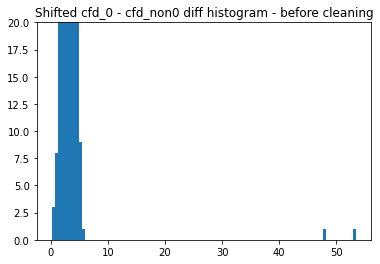

In [6]:
plt.hist(abs(all_y - _all_y_ch_non0), bins=100)
plt.ylim(0, 20)
plt.title('Shifted cfd_0 - cfd_non0 diff histogram - before cleaning')
plt.show()

In [7]:
MAX_DIFF = 5

for channel in channels:
    all_X = all_channels_data_dict[channel][0]
    all_y = all_channels_data_dict[channel][1]
    _all_X_ch0 = all_channels_X_ch0[channel]
    _all_y_ch_non0 = all_channels_y_ch_non0[channel]
    
    mask = abs(all_y - _all_y_ch_non0) < MAX_DIFF

    _all_X_ch0_cleaned = _all_X_ch0[mask]
    all_X_cleaned = all_X[mask]
    all_y_cleaned = all_y[mask]
    _all_y_ch_non0_cleaned = _all_y_ch_non0[mask]
    
    all_channels_data_dict[channel][0] = all_X_cleaned
    all_channels_data_dict[channel][1] = all_y_cleaned
    all_channels_X_ch0[channel] = _all_X_ch0_cleaned
    all_channels_y_ch_non0[channel] = _all_y_ch_non0_cleaned

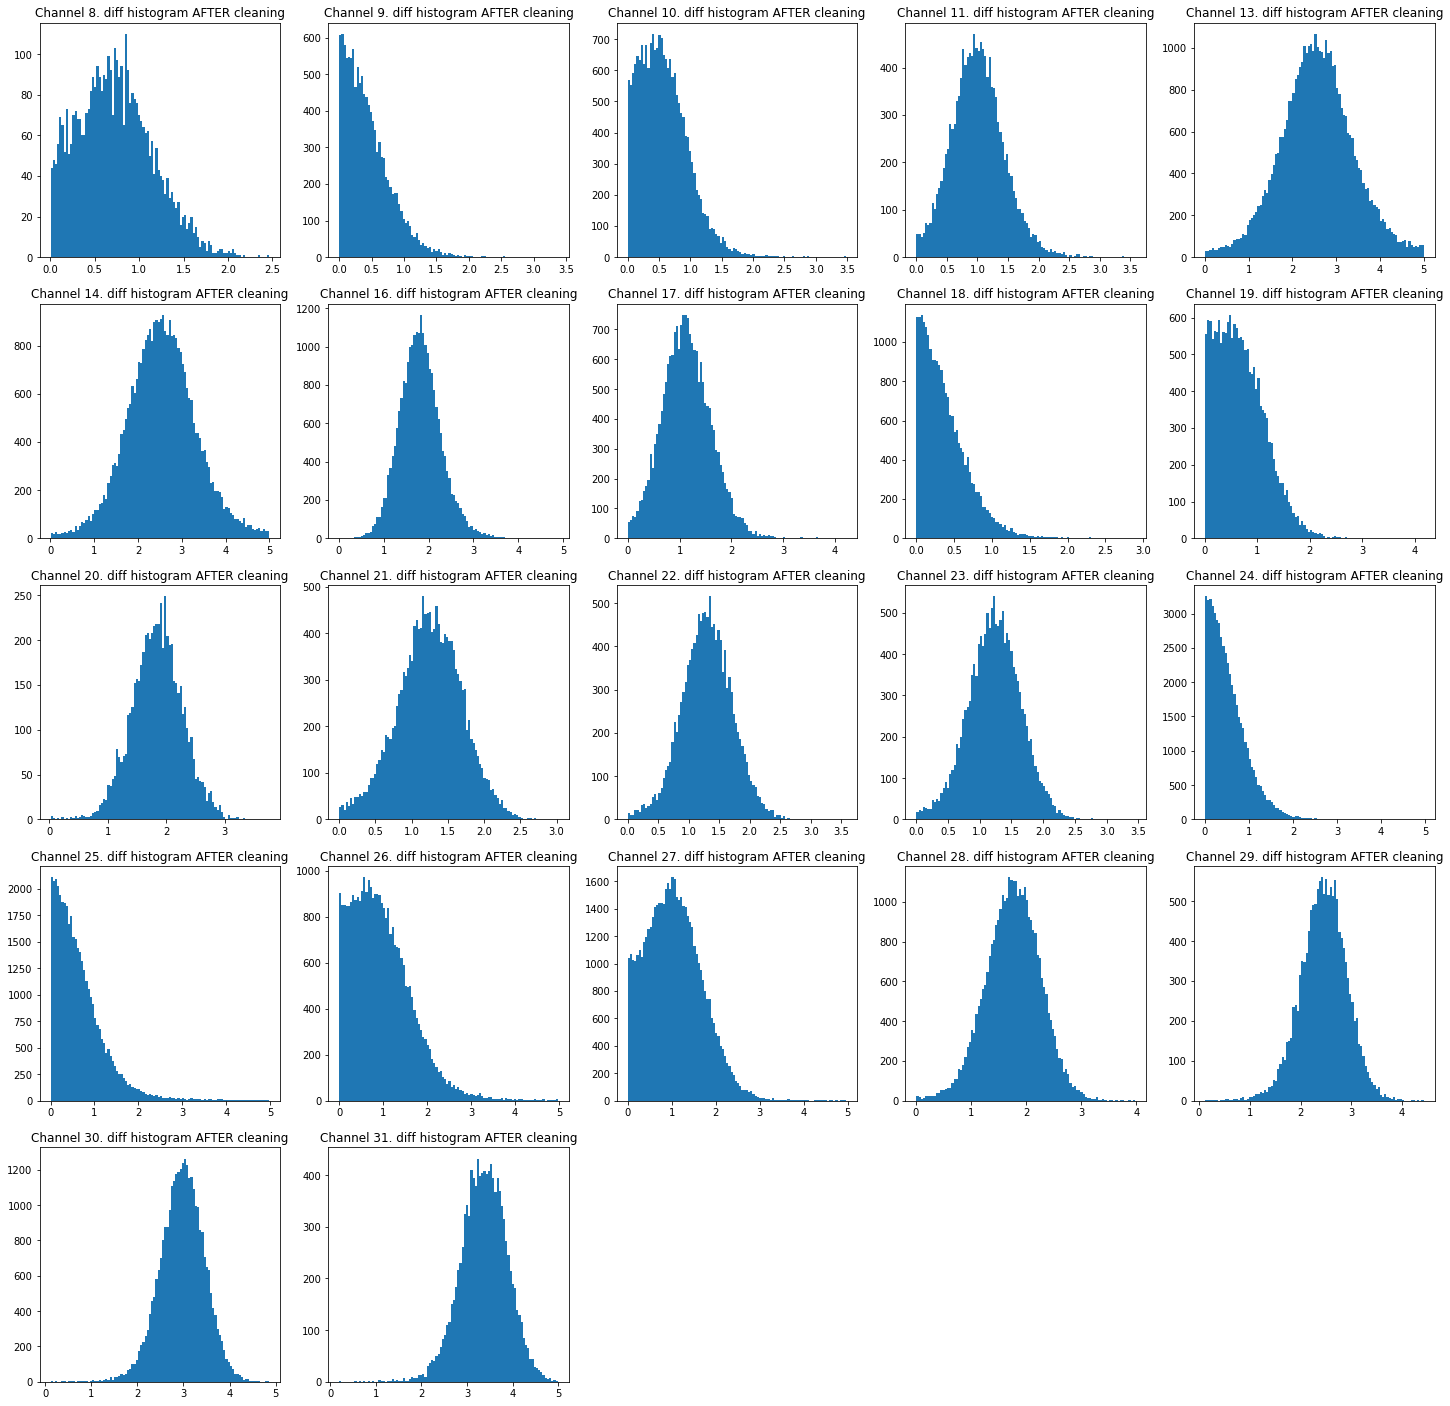

In [8]:
plt.figure(figsize=(25, 25))
for i, channel in enumerate(channels):
    # print(channel)
    plt.subplot(5, 5, i + 1)
    plt.hist(abs(all_channels_data_dict[channel][1] - all_channels_y_ch_non0[channel]), bins=100)
    plt.title(f'Channel {channel}. diff histogram AFTER cleaning')
plt.show()

## Save

In [9]:
np.savez_compressed(PWD + f'/data/dataset.npz', dataset=all_channels_data_dict)

# Check
- vertical red - ground truth
- vertical yellow - predicted by CFD

In [10]:
def normalize(X, n_baseline=20):
    X -= np.mean(X[:n_baseline])
    X /= X.max()
    return X

def plot_samples(indices):
    for i, idx in enumerate(indices):
        plt.subplot(2, 4, i + 1)
        plot_sample(normalize(_all_X_ch0_cleaned[idx]))
        y = cfd.predict(_all_X_ch0_cleaned[idx]) # to avoid shifting
        plt.axvline(y, c='red')
        plt.title(f'{y:0.4f}')
        plt.axhline(0, c='black', linestyle='--')
        plt.axhline(0.25, c='orange', linestyle='--')
        
        plt.subplot(2, 4, 4 + i + 1)
        plot_sample(normalize(all_X_cleaned[idx]))
        y = all_y_cleaned[idx]
        plt.axvline(y, c='red')
        y_pred = cfd.predict(all_X_cleaned[idx])
        plt.axvline(y_pred, c='orange', linestyle='--')
        plt.title(f'{y:0.4f}, diff={y_pred - y:0.4f}')
        plt.axhline(0, c='black', linestyle='--')
        plt.axhline(0.25, c='orange', linestyle='--')

In [11]:
all_channels_data_dict.keys()

dict_keys([8, 9, 10, 11, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

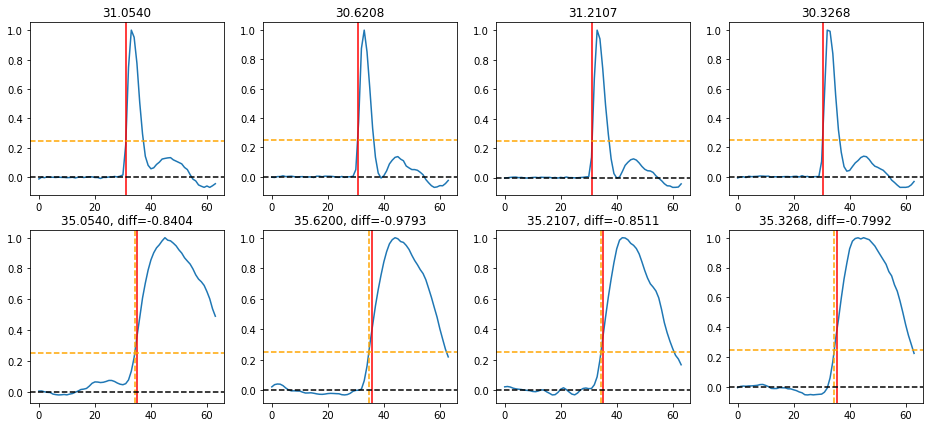

In [12]:
channel = 8

all_X_cleaned, all_y_cleaned = all_channels_data_dict[channel]
_all_X_ch0_cleaned = all_channels_X_ch0[channel]
_all_y_ch_non0_cleaned = all_channels_y_ch_non0[channel]

plt.figure(figsize=(16, 7))
plot_samples([0, 1000, 2000, 3000])

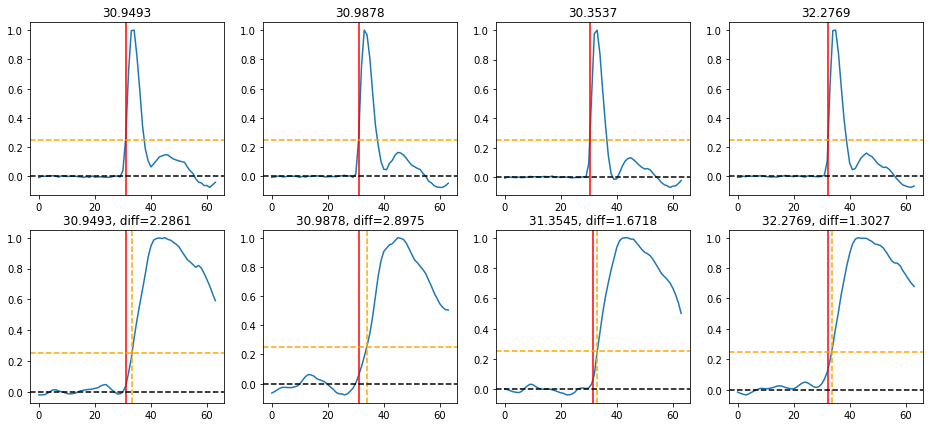

In [13]:
channel = 16

all_X_cleaned, all_y_cleaned = all_channels_data_dict[channel]
_all_X_ch0_cleaned = all_channels_X_ch0[channel]
_all_y_ch_non0_cleaned = all_channels_y_ch_non0[channel]

plt.figure(figsize=(16, 7))
plot_samples([0, 1000, 2000, 3000])

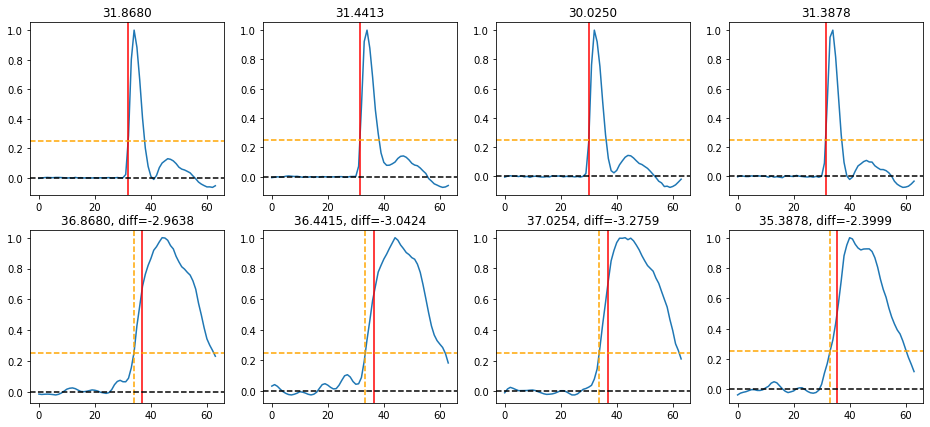

In [14]:
channel = 30

all_X_cleaned, all_y_cleaned = all_channels_data_dict[channel]
_all_X_ch0_cleaned = all_channels_X_ch0[channel]
_all_y_ch_non0_cleaned = all_channels_y_ch_non0[channel]

plt.figure(figsize=(16, 7))
plot_samples([0, 1000, 2000, 3000])